### Setting up

In [2]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("Spotify") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .getOrCreate()

24/12/07 16:30:12 WARN Utils: Your hostname, Elif-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.43.117 instead (on interface en0)
24/12/07 16:30:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 16:30:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/07 16:30:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/07 16:30:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/12/07 16:30:14 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/12/07 16:30:14 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
df= spark.read.format("csv").load("top_podcasts.csv", header=True, inferSchema=True, quote='"', escape = '"')

In [4]:
df.printSchema()


root
 |-- date: date (nullable = true)
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- episodeUri: string (nullable = true)
 |-- showUri: string (nullable = true)
 |-- episodeName: string (nullable = true)
 |-- description: string (nullable = true)
 |-- show.name: string (nullable = true)
 |-- show.description: string (nullable = true)
 |-- show.publisher: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- is_externally_hosted: boolean (nullable = true)
 |-- is_playable: boolean (nullable = true)
 |-- language: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- release_date_precision: string (nullable = true)
 |-- show.copyrights: string (nullable = true)
 |-- show.explicit: boolean (nullable = true)
 |-- show.href: string (nullable = true)
 |-- show.html_description: string (nullable =

In [5]:
df.select("date", "rank", "region", "episodeName", "duration_ms").show(truncate=True)


+----------+----+------+--------------------+-----------+
|      date|rank|region|         episodeName|duration_ms|
+----------+----+------+--------------------+-----------+
|2024-09-02|   1|    us|  #2197 - Mike Baker|    9872105|
|2024-09-02|   2|    us|#2195 - Andrew Hu...|   11250345|
|2024-09-02|   3|    us|#2196 - Greg Fitz...|   10840020|
|2024-09-02|   4|    us|The Worst Creatur...|    1073386|
|2024-09-02|   5|    us|Jeffrey Sachs: Tr...|    8896992|
|2024-09-02|   6|    us|The Most Unhinged...|    1096596|
|2024-09-02|   7|    us|CFB Mega Preview ...|   10452192|
|2024-09-02|   8|    us|407 - The Mushroo...|    4145606|
|2024-09-02|   9|    us|Copying BRATS on ...|     556308|
|2024-09-02|  10|    us|The Trad Wife Par...|    3408533|
|2024-09-02|  11|    us|Armchair Anonymou...|    2983706|
|2024-09-02|  12|    us|Reddit Soup For T...|    3761789|
|2024-09-02|  13|    us|The Only Way Germ...|    1256853|
|2024-09-02|  14|    us|For Kamala Harris...|    1156231|
|2024-09-02|  

#### Problem with dots
The error arises because PySpark treats column names containing dots (.) as nested structures, which need to be accessed differently. 
In your dataset, show.name is not treated as a simple column name;
instead, it’s considered a field in a structure or a column with a literal dot in its name.

In [7]:
from pyspark.sql.functions import col

# replacing column names
renamed_columns = {col_name: col_name.replace(".", "_") for col_name in df.columns}
for old_name, new_name in renamed_columns.items():
    df = df.withColumnRenamed(old_name, new_name)

df.printSchema()




root
 |-- date: date (nullable = true)
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- episodeUri: string (nullable = true)
 |-- showUri: string (nullable = true)
 |-- episodeName: string (nullable = true)
 |-- description: string (nullable = true)
 |-- show_name: string (nullable = true)
 |-- show_description: string (nullable = true)
 |-- show_publisher: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- is_externally_hosted: boolean (nullable = true)
 |-- is_playable: boolean (nullable = true)
 |-- language: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- release_date_precision: string (nullable = true)
 |-- show_copyrights: string (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_href: string (nullable = true)
 |-- show_html_description: string (nullable =

In [8]:
# nulls check
# not expected since api but still

from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import DoubleType, FloatType
import pandas as pd

# numeric vs non
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, FloatType))]
non_numeric_columns = [field.name for field in df.schema.fields if field.name not in numeric_columns]

# nan in numeric
numeric_nulls = [
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in numeric_columns
]

# nan in non numeric
non_numeric_nulls = [
    count(when(col(c).isNull(), c)).alias(c) for c in non_numeric_columns
]

null_counts_df = df.select(numeric_nulls + non_numeric_nulls)
null_counts = null_counts_df.toPandas().transpose().reset_index()
null_counts.columns = ["Column", "Null_Count"]

print(null_counts)

#nulls only in description and show_html_desc which is unrelated to my analysis so no action needed

24/12/07 16:30:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


                       Column  Null_Count
0                        date           0
1                        rank           0
2                      region           0
3               chartRankMove           0
4                  episodeUri           0
5                     showUri           0
6                 episodeName           0
7                 description        2621
8                   show_name           0
9            show_description           0
10             show_publisher           0
11                duration_ms           0
12                   explicit           0
13       is_externally_hosted           0
14                is_playable           0
15                   language           0
16                  languages           0
17               release_date           0
18     release_date_precision           0
19            show_copyrights           0
20              show_explicit           0
21                  show_href           0
22      show_html_description     

### Data Prep

In [10]:

columns_to_drop = [
    "episodeUri", "showUri","show_uri", "description", "show_description",
    "show_html_description", "show_href", "show_copyrights",
    "show_is_externally_hosted",
    "is_externally_hosted", "is_playable", "release_date_precision", 
    "show_type"
]

df = df.drop(*columns_to_drop)


df.printSchema()


root
 |-- date: date (nullable = true)
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- episodeName: string (nullable = true)
 |-- show_name: string (nullable = true)
 |-- show_publisher: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- language: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_languages: string (nullable = true)
 |-- show_media_type: string (nullable = true)
 |-- show_total_episodes: integer (nullable = true)



#### Handling Languages

In [12]:
# correlation check for languages columns
from pyspark.ml.feature import StringIndexer

indexer_show_languages = StringIndexer(inputCol="show_languages", outputCol="show_languages_index")
indexer_language = StringIndexer(inputCol="language", outputCol="language_index")
indexer_languages = StringIndexer(inputCol="languages", outputCol="languages_index")

df = indexer_show_languages.fit(df).transform(df)
df = indexer_language.fit(df).transform(df)
df = indexer_languages.fit(df).transform(df)


In [13]:
correlation = df.stat.corr("language_index", "languages_index")
print(f"Correlation between language and languages: {correlation}")


Correlation between language and languages: 1.0


In [14]:
correlation = df.stat.corr("language_index", "show_languages_index")
print(f"Correlation between language and show languages: {correlation}")

Correlation between language and show languages: 0.9997772079125222


In [15]:
from pyspark.sql.functions import split

# new column with the base language
df = df.withColumn("base_language", split(df["language"], "-")[0])


In [16]:
# checking counts
language_groups = df.groupBy("base_language").count()

language_groups.show()


+-------------+-----+
|base_language|count|
+-------------+-----+
|           en|76841|
|          und|  355|
|           ur|   91|
|           pl|10010|
|           pt|10187|
|           tl| 1951|
|           jv|    5|
|           mr|    3|
|           de|20259|
|           es|49955|
|           it| 9697|
|           te|  152|
|           ar|  277|
|           nl| 9905|
|           bn|  314|
|           ca|  772|
|          fil| 1225|
|           ml|   21|
|           pa|  338|
|           hi| 5032|
+-------------+-----+
only showing top 20 rows



In [17]:
df = df.drop("language", "languages", "show_languages", "languages_index", "show_languages_index","language_index" )

In [18]:
# now we have base_language only

#### Handling date

In [20]:
# turn date & release_date into days since release (int) and drop the previous columns
# will drop date and release_date at the end of setting up new columns because we still need them for now
from pyspark.sql.functions import datediff

df = df.withColumn("released_since_days", datediff("date", "release_date"))


### Setting up new columns

#### Prev_rank, rank_movement

In [23]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, when

# window partitioned by region and show, ordered by date
window_spec = Window.partitionBy("region", "show_name").orderBy("date")

# previous day's rank
df = df.withColumn("prev_rank", lag("rank").over(window_spec))

# new target column: 1= up 0= down or sam
df = df.withColumn("rank_movement", when(col("rank") < col("prev_rank"), 1).otherwise(0))

#replacing nulls with 201 -to mark them correctly as up when the podcast is new to the list 
df = df.withColumn("prev_rank", when(col("prev_rank").isNull(), 201).otherwise(col("prev_rank")))



In [24]:
df.select("date", "region", "show_name", "rank", "prev_rank", "rank_movement").show(10)


+----------+------+-------------------+----+---------+-------------+
|      date|region|          show_name|rank|prev_rank|rank_movement|
+----------+------+-------------------+----+---------+-------------+
|2024-09-04|    ar|Aprender de Grandes| 197|      201|            0|
|2024-09-05|    ar|Aprender de Grandes| 184|      197|            1|
|2024-09-06|    ar|Aprender de Grandes| 180|      184|            1|
|2024-09-08|    ar|Aprender de Grandes| 197|      180|            0|
|2024-09-12|    ar|Aprender de Grandes| 158|      197|            1|
|2024-09-13|    ar|Aprender de Grandes| 168|      158|            0|
|2024-09-14|    ar|Aprender de Grandes| 179|      168|            0|
|2024-09-15|    ar|Aprender de Grandes| 170|      179|            1|
|2024-09-16|    ar|Aprender de Grandes| 166|      170|            1|
|2024-09-20|    ar|Aprender de Grandes| 136|      166|            1|
+----------+------+-------------------+----+---------+-------------+
only showing top 10 rows



#### Average Time in the ranks

In [26]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window


# times_in_top_200_episode for each episode
episode_window = Window.partitionBy("show_name", "episodeName")
df = df.withColumn("times_in_top_200_episode", F.count("*").over(episode_window))

# total distinct episodes per show
distinct_episodes = df.select("show_name", "episodeName") \
    .distinct() \
    .groupBy("show_name") \
    .agg(F.count("episodeName").alias("total_episodes_per_show"))

# total times in top 200 per show
show_times = df.groupBy("show_name").agg(
    F.sum("times_in_top_200_episode").alias("total_times_in_top_200")
)

# join both totals back into the DataFrame
df = df.join(distinct_episodes, on="show_name", how="left") \
       .join(show_times, on="show_name", how="left")

# calculate avg_times_in_top_200_per_show, round to 2 decimals

df = df.withColumn(
    "avg_times_in_top_200_per_show",
    F.round(F.col("total_times_in_top_200") / F.col("total_episodes_per_show"), 2)  )

# remove duplicates for final display
df = df.dropDuplicates(["show_name", "episodeName"])

df.select("show_name", "episodeName", "times_in_top_200_episode",
          "total_episodes_per_show", "avg_times_in_top_200_per_show").show(10)


+--------------------+--------------------+------------------------+-----------------------+-----------------------------+
|           show_name|         episodeName|times_in_top_200_episode|total_episodes_per_show|avg_times_in_top_200_per_show|
+--------------------+--------------------+------------------------+-----------------------+-----------------------------+
|Better Me (Hopefu...|I’ve fallen off t...|                       1|                      3|                          2.0|
|Between Two Beers...|Lessons from Seri...|                       9|                     14|                        72.43|
|Between Two Beers...|Rachel Hunter Sto...|                       5|                     14|                        72.43|
|Call Me Back - wi...|NASRALLAH DEAD, H...|                       2|                      1|                          4.0|
|Dan Snow's Histor...|Operation Market ...|                       3|                     23|                         14.0|
|Dan Snow's Hist

In [27]:
df.printSchema()

root
 |-- show_name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- episodeName: string (nullable = true)
 |-- show_publisher: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- release_date: date (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_media_type: string (nullable = true)
 |-- show_total_episodes: integer (nullable = true)
 |-- base_language: string (nullable = true)
 |-- released_since_days: integer (nullable = true)
 |-- prev_rank: integer (nullable = true)
 |-- rank_movement: integer (nullable = false)
 |-- times_in_top_200_episode: long (nullable = false)
 |-- total_episodes_per_show: long (nullable = true)
 |-- total_times_in_top_200: long (nullable = true)
 |-- avg_times_in_top_200_per_show: double (nullable = true)



In [28]:
#checking correlation between target column and show_name and publisher, to see if either is worth keeping
indexer_show_name = StringIndexer(inputCol="show_name", outputCol="show_name_index")
indexer_show_publisher = StringIndexer(inputCol="show_publisher", outputCol="show_publisher_index")

df = indexer_show_name.fit(df).transform(df)
df = indexer_show_publisher.fit(df).transform(df)



In [29]:
correlation = df.stat.corr("show_name_index", "rank_movement")
print(f"Correlation between show_name and target: {correlation}")

Correlation between show_name and target: -0.05828857550169572


In [30]:
correlation = df.stat.corr("show_publisher_index", "rank_movement")
print(f"Correlation between show_publisher and target: {correlation}")

Correlation between show_publisher and target: -0.06479356734958078


In [31]:
#before proceeding, we drop the last batch of unnecessary columns 
df = df.drop("date", "release_date", "show_publisher", "show_publisher_index", "episodeName", "show_name_index", "show_name")

In [32]:
df.printSchema()

root
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_media_type: string (nullable = true)
 |-- show_total_episodes: integer (nullable = true)
 |-- base_language: string (nullable = true)
 |-- released_since_days: integer (nullable = true)
 |-- prev_rank: integer (nullable = true)
 |-- rank_movement: integer (nullable = false)
 |-- times_in_top_200_episode: long (nullable = false)
 |-- total_episodes_per_show: long (nullable = true)
 |-- total_times_in_top_200: long (nullable = true)
 |-- avg_times_in_top_200_per_show: double (nullable = true)



#### StringIndexing

In [34]:
# as a part of preprocessing because we will use it directly for decision trees and for logistic regression 
# we need this as a pre step of one hot encoding

In [35]:

from pyspark.sql.types import StringType

string_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

print("String columns:", string_columns)



String columns: ['region', 'chartRankMove', 'show_media_type', 'base_language']


In [36]:
from pyspark.ml.feature import StringIndexer

# stringindexer for string columns
for col in string_columns:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    df = indexer.fit(df).transform(df)

df.printSchema()


root
 |-- rank: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- chartRankMove: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_media_type: string (nullable = true)
 |-- show_total_episodes: integer (nullable = true)
 |-- base_language: string (nullable = true)
 |-- released_since_days: integer (nullable = true)
 |-- prev_rank: integer (nullable = true)
 |-- rank_movement: integer (nullable = false)
 |-- times_in_top_200_episode: long (nullable = false)
 |-- total_episodes_per_show: long (nullable = true)
 |-- total_times_in_top_200: long (nullable = true)
 |-- avg_times_in_top_200_per_show: double (nullable = true)
 |-- region_index: double (nullable = false)
 |-- chartRankMove_index: double (nullable = false)
 |-- show_media_type_index: double (nullable = false)
 |-- base_language_index: double (nullable = false)



In [37]:
#dropping string columns before proceeding
df = df.drop(*string_columns)



In [38]:
df.printSchema()


root
 |-- rank: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_total_episodes: integer (nullable = true)
 |-- released_since_days: integer (nullable = true)
 |-- prev_rank: integer (nullable = true)
 |-- rank_movement: integer (nullable = false)
 |-- times_in_top_200_episode: long (nullable = false)
 |-- total_episodes_per_show: long (nullable = true)
 |-- total_times_in_top_200: long (nullable = true)
 |-- avg_times_in_top_200_per_show: double (nullable = true)
 |-- region_index: double (nullable = false)
 |-- chartRankMove_index: double (nullable = false)
 |-- show_media_type_index: double (nullable = false)
 |-- base_language_index: double (nullable = false)



In [39]:
df = df.drop("chartRankMove", "rank") # because these are directly correlated with our target column

In [40]:
# saving the preprocessed file for future use for reference
 #df.write.mode("overwrite").parquet("preprocessed_data3.parquet")

In [41]:
df2 = df.select("*")
# a copy because for logistic regression will go under scaling and one hot encoding

#### Logistic regression

In [43]:
# One hot encoding string indexed data
from pyspark.ml.feature import OneHotEncoder

index_cols = ["base_language_index", "show_media_type_index", "region_index"]
output_cols = [f"{col}_vector" for col in index_cols]

encoder = OneHotEncoder(inputCols=index_cols, outputCols=output_cols)
df2 = encoder.fit(df2).transform(df2)

df2.printSchema()


root
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_total_episodes: integer (nullable = true)
 |-- released_since_days: integer (nullable = true)
 |-- prev_rank: integer (nullable = true)
 |-- rank_movement: integer (nullable = false)
 |-- times_in_top_200_episode: long (nullable = false)
 |-- total_episodes_per_show: long (nullable = true)
 |-- total_times_in_top_200: long (nullable = true)
 |-- avg_times_in_top_200_per_show: double (nullable = true)
 |-- region_index: double (nullable = false)
 |-- chartRankMove_index: double (nullable = false)
 |-- show_media_type_index: double (nullable = false)
 |-- base_language_index: double (nullable = false)
 |-- base_language_index_vector: vector (nullable = true)
 |-- show_media_type_index_vector: vector (nullable = true)
 |-- region_index_vector: vector (nullable = true)



In [44]:
df2 = df2.drop(*index_cols)


In [45]:
# scaling

In [46]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

#long and double types
columns_to_scale = [
    "duration_ms",
    "show_total_episodes",
    "released_since_days",
    "times_in_top_200_episode",
    "total_episodes_per_show",
    "total_times_in_top_200",
    "avg_times_in_top_200_per_show"
]


In [47]:
# vector of features to scale
assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features_to_scale")
df2 = assembler.transform(df2)


In [48]:
# standardScaler
scaler = StandardScaler(inputCol="features_to_scale", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df2)
df2 = scaler_model.transform(df2)




In [49]:
#vector assembler


In [50]:

target_column = "rank_movement"

# columns for final feature vector
final_features_columns = [
    col for col in df2.columns if col not in columns_to_scale + [target_column] and col != "features_to_scale"
]


# vector assembler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=final_features_columns, outputCol="features")
df2 = assembler.transform(df2)

df2.printSchema()



root
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- show_explicit: boolean (nullable = true)
 |-- show_total_episodes: integer (nullable = true)
 |-- released_since_days: integer (nullable = true)
 |-- prev_rank: integer (nullable = true)
 |-- rank_movement: integer (nullable = false)
 |-- times_in_top_200_episode: long (nullable = false)
 |-- total_episodes_per_show: long (nullable = true)
 |-- total_times_in_top_200: long (nullable = true)
 |-- avg_times_in_top_200_per_show: double (nullable = true)
 |-- chartRankMove_index: double (nullable = false)
 |-- base_language_index_vector: vector (nullable = true)
 |-- show_media_type_index_vector: vector (nullable = true)
 |-- region_index_vector: vector (nullable = true)
 |-- features_to_scale: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [51]:
# final vector
df2.select("features").show()

# columns in it
print(f"Columns included in 'features': {final_features_columns}")


+--------------------+
|            features|
+--------------------+
|(60,[2,10,36,53,5...|
|(60,[2,10,36,53,5...|
|(60,[2,3,4,52,53,...|
|(60,[2,6,48,53,54...|
|(60,[2,3,10,31,36...|
|(60,[2,10,31,36,5...|
|(60,[2,7,31,32,53...|
|(60,[2,6,31,48,53...|
|(60,[2,6,31,48,53...|
|(60,[2,6,31,48,53...|
|(60,[2,6,31,48,53...|
|(60,[2,6,31,48,53...|
|(60,[2,6,31,48,53...|
|(60,[2,5,31,45,53...|
|(60,[2,5,31,45,53...|
|(60,[2,5,31,45,53...|
|(60,[2,5,31,45,53...|
|(60,[2,5,31,45,53...|
|(60,[2,5,31,45,53...|
|(60,[2,5,31,45,53...|
+--------------------+
only showing top 20 rows

Columns included in 'features': ['explicit', 'show_explicit', 'prev_rank', 'chartRankMove_index', 'base_language_index_vector', 'show_media_type_index_vector', 'region_index_vector', 'scaled_features']


In [71]:
# logistic regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

train_df, test_df = df2.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol="rank_movement", maxIter=10)

lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)



#evaluators
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="rank_movement", predictionCol="prediction")

accuracy = multiclass_evaluator.setMetricName("accuracy").evaluate(predictions)
f1_score = multiclass_evaluator.setMetricName("f1").evaluate(predictions)
precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(predictions)
binary_evaluator = BinaryClassificationEvaluator(labelCol="rank_movement", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)

#metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Area Under ROC (AUC): {auc:.4f}")


Accuracy: 0.6556
F1-Score: 0.6554
Precision: 0.6558
Recall: 0.6556
Area Under ROC (AUC): 0.7044


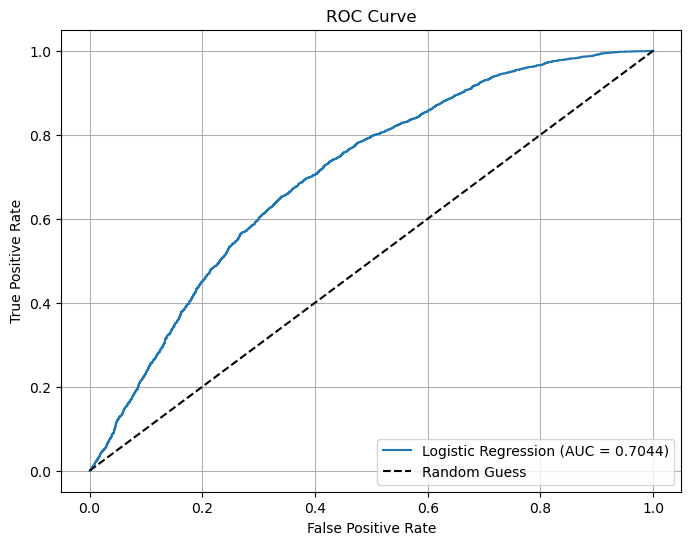

In [73]:
# roc curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
import pandas as pd
import matplotlib.pyplot as plt


predictions = predictions.withColumn("probabilities", vector_to_array("probability"))
roc_data = predictions.select("rank_movement", F.col("probabilities")[1].alias("positive_probability"))
roc_pandas = roc_data.toPandas()

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(roc_pandas["rank_movement"], roc_pandas["positive_probability"])


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Decision Tree

In [ ]:
# vector assembler

In [ ]:
target_column = "rank_movement"
all_columns = df.columns

# columns for final feature vector
final_features_columns = [col for col in all_columns if col != target_column]

# vector assembler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=final_features_columns, outputCol="features")
df = assembler.transform(df)

df.printSchema()


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

dt = DecisionTreeClassifier(featuresCol="features", labelCol="rank_movement", maxDepth=5)
dt_model = dt.fit(train_df)

# have the predictions
predictions = dt_model.transform(test_df)

# evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="rank_movement", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
f1_score = evaluator.setMetricName("f1").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")




In [ ]:
# feature importance
print("Feature Importances: ", dt_model.featureImportances)

# indices to column names
for i, importance in enumerate(dt_model.featureImportances):
    print(f"Feature {i}: {final_features_columns[i]} => Importance: {importance:.4f}")


In [ ]:
#saving parameters for future reference
best_params = {
    'maxDepth': 15,
    'maxBins': 128,
    'minInstancesPerNode': 5,
    'minInfoGain': 0.0
}


In [ ]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="rank_movement", maxDepth=15,
    maxBins=128,
    minInstancesPerNode=5,
    minInfoGain=0.0)
best_model = dt.fit(train_df)


In [ ]:
# Evaluate the best model, got slightly better
predictions = best_model.transform(test_df)
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
f1_score = evaluator.setMetricName("f1").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

print(f"Best Model Test Accuracy: {accuracy:.4f}")
print(f"Best Model F1-Score: {f1_score:.4f}")
print(f"Best Model Precision: {precision:.4f}")
print(f"Best Model Recall: {recall:.4f}")


In [ ]:
# feature importance
print("Feature Importances: ", best_model.featureImportances)

# indices to column names
for i, importance in enumerate(best_model.featureImportances):
    print(f"Feature {i}: {final_features_columns[i]} => Importance: {importance:.4f}")

#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(featuresCol="features", labelCol="rank_movement", numTrees=50, maxDepth=10)
rf_model = rf.fit(train_df)
predictions = rf_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="rank_movement", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions)
print(f" Accuracy: {accuracy:.4f}")
print(f" F1-Score: {f1_score:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")


In [75]:

# from previous dt search

rf = RandomForestClassifier(featuresCol="features", labelCol="rank_movement", seed=42,maxDepth=15,
    maxBins=128,
    minInstancesPerNode=5,
    minInfoGain=0.0 )

# additional Random Forest-specific parameters
rf = rf.setNumTrees(100) \
       .setFeatureSubsetStrategy("sqrt")

rf_model = rf.fit(train_df)
predictions = rf_model.transform(test_df)

#evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="rank_movement", predictionCol="prediction")

accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
f1_score = evaluator.setMetricName("f1").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



24/12/07 16:50:54 WARN DAGScheduler: Broadcasting large task binary with size 1316.4 KiB
24/12/07 16:50:54 WARN DAGScheduler: Broadcasting large task binary with size 1919.0 KiB
24/12/07 16:50:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/07 16:50:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/12/07 16:51:00 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/12/07 16:51:03 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/12/07 16:51:06 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
24/12/07 16:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1088.1 KiB
24/12/07 16:51:12 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
24/12/07 16:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1262.6 KiB
24/12/07 16:51:17 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
24/12/07 16:51:23 WARN DAGScheduler: Bro

Accuracy: 0.8025
F1-Score: 0.8024
Precision: 0.8029
Recall: 0.8025


24/12/07 16:53:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/12/07 16:53:32 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/12/07 16:53:32 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/12/07 16:53:33 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/12/07 16:53:42 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/12/07 16:53:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/12/07 16:53:46 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


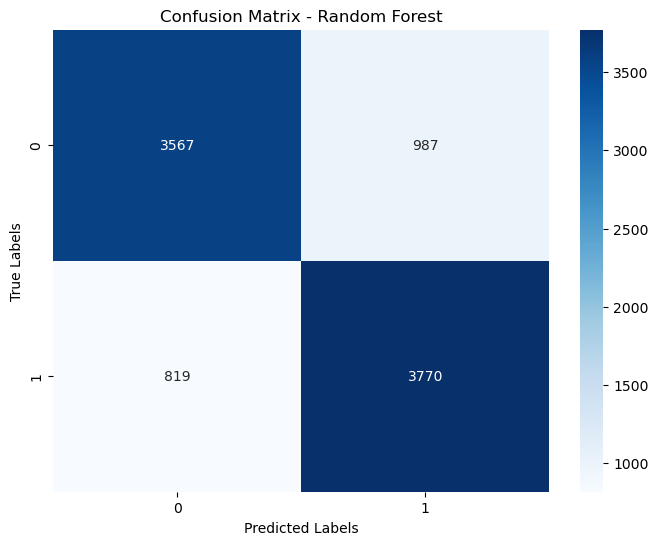

In [77]:
# confusion matrix
confusion_matrix_df = predictions.groupBy("rank_movement", "prediction").count()

confusion_matrix_pivot = confusion_matrix_df.groupBy("rank_movement").pivot("prediction").sum("count").fillna(0)
confusion_matrix_pandas = confusion_matrix_pivot.toPandas()

labels = sorted(confusion_matrix_pandas["rank_movement"].tolist())  # Ensure correct order of labels
confusion_matrix_pandas = confusion_matrix_pandas.set_index("rank_movement").reindex(labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pandas, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()